In [1]:
! python -c "import torch; print('CUDA available:', torch.cuda.is_available())"

CUDA available: True


In [27]:
! python train.py --name your_experiment --netG unet_256 --n_epochs 100 --lr 0.0002

🚀 启动训练脚本...
   加载扫描参数: ./datasets/simulation/resolution_distorsion/resolution_distorsion_simu_scan.hdf5
   加载数据文件: ./datasets/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_iq.hdf5
   IQ数据形状: (75, 128, 382)
   发射角度数: 75
   中心频率: 5.21 MHz
   采样频率: 5.21 MHz
   声速: 1540.0 m/s
   时间零点扩展到所有角度
   验证数据完整性...
   ✅ PICMUS数据加载完成并验证通过
----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: vanilla                       
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from matplotlib.font_manager import FontProperties

import importlib
import sys

# Force reload of the modified module
if 'cubdl.das_torch' in sys.modules:
    importlib.reload(sys.modules['cubdl.das_torch'])
if 'cubdl.example_picmus_torch' in sys.modules:
    importlib.reload(sys.modules['cubdl.example_picmus_torch'])

# 设置中文字体
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
chinese_font = FontProperties(fname=font_path)

# 全局设置
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

sys.path.append('/home/liujia/dev/AUGAN_725')
from cubdl.example_picmus_torch import load_datasets, create_network, mk_img

plane_wave_data = load_datasets("simulation", "resolution_distorsion", "iq")

print(plane_wave_data)

print(f"数据类型：{type(plane_wave_data)}")
print(f"发射角度数：{len(plane_wave_data.angles)}")
print(f"IQ数据形状：{plane_wave_data.idata.shape}")
print(f"传感器位置：{plane_wave_data.ele_pos.shape}")
print(f"中心频率：{plane_wave_data.fc/1e6:.1f} MHz")
print(F"采样频率：{plane_wave_data.fs/1e6:.1f}")


single_angle = [37]
das_single, iqdata, xlims, zlims = create_network(plane_wave_data, single_angle)
print(f"单角度DAS网络创建完成，使用角度：{single_angle}")

few_angle = [35, 36, 37, 38, 39]
das_few, _, _, _ = create_network(plane_wave_data, few_angle)
print(f"少角度DAS网络创建完成，使用角度：{len(few_angle)}")

all_angle = list(range(len(plane_wave_data.angles)))
das_multi, _, _, _ = create_network(plane_wave_data, all_angle)
print(f"多角度DAS网络创建完成，使用角度：{len(all_angle)}")

print(f"成像区域：X=[{xlims[0]*1000:.1f}, {xlims[1]*1000:.1f}]mm")
print(f"成像区域：Z=[{xlims[0]*1000:.1f}, {xlims[1]*1000:.1f}]mm")

   加载扫描参数: ./datasets/simulation/resolution_distorsion/resolution_distorsion_simu_scan.hdf5
   加载数据文件: ./datasets/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_iq.hdf5
   IQ数据形状: (75, 128, 382)
   发射角度数: 75
   中心频率: 5.21 MHz
   采样频率: 5.21 MHz
   声速: 1540.0 m/s
   时间零点扩展到所有角度
   验证数据完整性...
   ✅ PICMUS数据加载完成并验证通过
数据类型：<class 'cubdl.PlaneWaveData.PICMUSData'>
发射角度数：75
IQ数据形状：(75, 128, 382)
传感器位置：(128, 3)
中心频率：5.2 MHz
采样频率：5.2
单角度DAS网络创建完成，使用角度：[37]
少角度DAS网络创建完成，使用角度：5
多角度DAS网络创建完成，使用角度：75
成像区域：X=[-19.1, 19.1]mm
成像区域：Z=[-19.1, 19.1]mm


In [2]:
print("\n 第三步：执行DAS图像重建")
print("重建单角度图像...")
single_img = mk_img(das_single, iqdata)

print(" 重建少角度图像...")
few_img = mk_img(das_few, iqdata)

print(" 重建多角度图像...")
multi_img = mk_img(das_multi, iqdata)
print(f" 单角度图像形状：{single_img.shape}")
print(f" 少角度图像形状：{few_img.shape}")
print(f" 多角度图像形状：{multi_img.shape}")


 第三步：执行DAS图像重建
重建单角度图像...


/home/liujia/anaconda3/envs/augan38/lib/python3.8/site-packages/torch/nn/functional.py:4373: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


 重建少角度图像...
 重建多角度图像...
 单角度图像形状：(508, 387)
 少角度图像形状：(508, 387)
 多角度图像形状：(508, 387)


In [37]:
print("\n 📊第四步：分析数据的图像质量")

def analyze_ultrasound_quality(img, name):
    img_db = 20 * np.log10(np.abs(img) + 1e-10)
    img_db -= np.max(img_db)
    
    mean_val = np.mean(img_db)
    std_val = np.std(img_db)
    dynamic_range = np.max(img_db) - np.min(img_db)
    
    print(f"{name}")
    print(f"平均强度：{mean_val:.1f} dB")
    print(f"标准差：{std_val:.1f} dB")
    print(f"动态范围：{dynamic_range:.1f} dB")
    
    return img_db, {'mean': mean_val, 'std': std_val, 'range': dynamic_range}

single_db, single_stats = analyze_ultrasound_quality(single_img, "单角度重建")
few_db, few_stats = analyze_ultrasound_quality(few_img, "少角度重建")
multi_db, multi_stats = analyze_ultrasound_quality(multi_img, "多角度重建（目标质量）")



    


 📊第四步：分析数据的图像质量
单角度重建
平均强度：-8.7 dB
标准差：3.9 dB
动态范围：64.8 dB
少角度重建
平均强度：-8.1 dB
标准差：3.2 dB
动态范围：76.0 dB
多角度重建（目标质量）
平均强度：-7.3 dB
标准差：2.4 dB
动态范围：76.1 dB


🎯 DAS Reconstruction with Real PICMUS Data
📡 Step 1: Load Real PICMUS Data
   Data Type: <class 'cubdl.PlaneWaveData.PICMUSData'>
   Number of Angles: 75
   IQ Data Shape: (75, 128, 382)
   Element Positions: (128, 3)
   Center Frequency: 5.2 MHz
   Sampling Frequency: 5.2 MHz

🔬 Step 2: Create DAS Reconstruction Networks
   Single-angle DAS network created, using angles: [37]
   Few-angle DAS network created, using 5 angles
   Multi-angle DAS network created, using 75 angles
   Imaging Range: X=[-19.1, 19.1]mm
   Imaging Range: Z=[5.0, 55.0]mm

🖼️  Step 3: Perform Real DAS Image Reconstruction
   Reconstructing single-angle image...


/home/liujia/anaconda3/envs/augan38/lib/python3.8/site-packages/torch/nn/functional.py:4373: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


   Reconstructing few-angle image...
   Reconstructing multi-angle image...
   Single-angle image shape: (508, 387)
   Few-angle image shape: (508, 387)
   Multi-angle image shape: (508, 387)

📊 Step 4: Analyze Real Data Image Quality
   Single-angle Reconstruction:
     Mean Intensity: -8.7 dB
     Standard Deviation: 3.9 dB
     Dynamic Range: 64.8 dB
   Few-angle Reconstruction:
     Mean Intensity: -8.1 dB
     Standard Deviation: 3.2 dB
     Dynamic Range: 76.0 dB
   Multi-angle Reconstruction (Target Quality):
     Mean Intensity: -7.3 dB
     Standard Deviation: 2.4 dB
     Dynamic Range: 76.1 dB

📈 Step 5: Visualize Real Ultrasound Reconstruction Results
   Real data reconstruction plot saved to: step2_Real_PICMUS_Data_Reconstruction.png


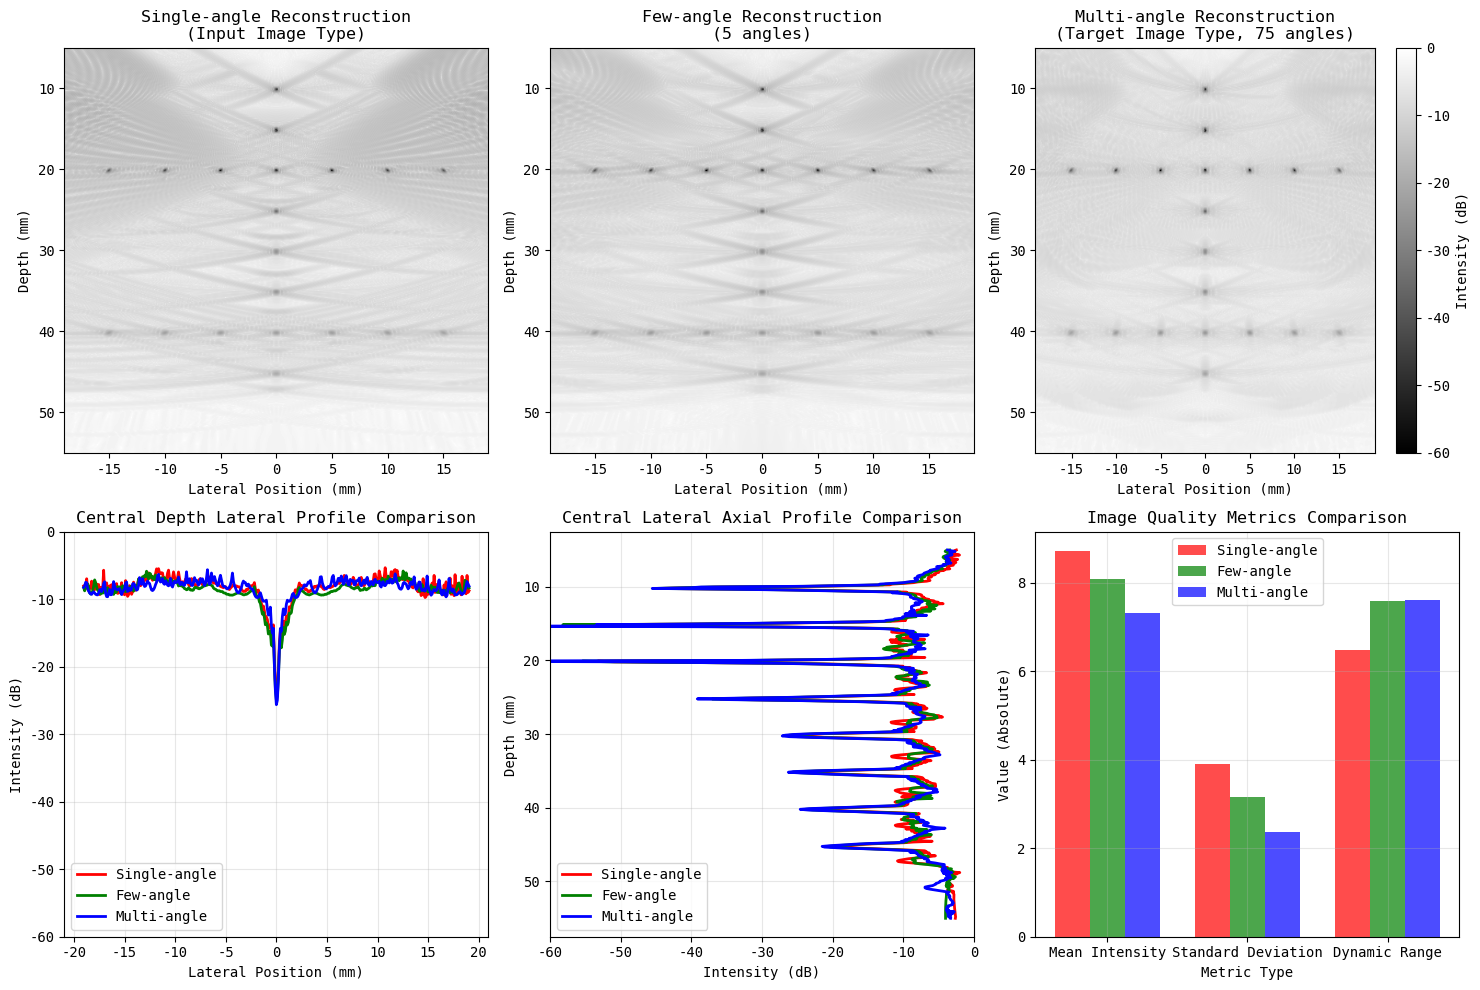


🎓 Real Data Version Summary:
   1. Used real PICMUS ultrasound data from the project
   2. Observed real ultrasound image quality differences
   3. Single-angle images indeed have lower quality than multi-angle images
   4. This is the input→output mapping that AUGAN needs to learn!

📏 Real Data Scale:
   - Image Size: (508, 387)
   - Imaging Range: 0.038m × 0.050m
   - Transmission Angles: 75


In [35]:
#!/usr/bin/env python3
"""
AUGAN Study - Step2: DAS Reconstruction with Real PICMUS Data (English Version)
"""

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import warnings

# 忽略字体警告
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# 设置matplotlib字体，避免字体警告
plt.rcParams['font.family'] = 'monospace'  # 使用等宽字体
plt.rcParams['font.size'] = 10

# Import AUGAN project modules
sys.path.append('/home/liujia/dev/AUGAN_725')
from cubdl.example_picmus_torch import load_datasets, create_network, mk_img

print("🎯 DAS Reconstruction with Real PICMUS Data")
print("="*50)

# ===== Step 1: Load Real PICMUS Data =====
print("📡 Step 1: Load Real PICMUS Data")

# Load data (same as training script)
plane_wave_data = load_datasets("simulation", "resolution_distorsion", "iq")

print(f"   Data Type: {type(plane_wave_data)}")
print(f"   Number of Angles: {len(plane_wave_data.angles)}")
print(f"   IQ Data Shape: {plane_wave_data.idata.shape}")
print(f"   Element Positions: {plane_wave_data.ele_pos.shape}")
print(f"   Center Frequency: {plane_wave_data.fc/1e6:.1f} MHz")
print(f"   Sampling Frequency: {plane_wave_data.fs/1e6:.1f} MHz")

# ===== Step 2: Create DAS Networks with Different Angles =====
print("\n🔬 Step 2: Create DAS Reconstruction Networks")

# 1. Single-angle network (angle 38, around 0 degrees)
single_angle = [37]  # Center angle
das_single, iqdata, xlims, zlims = create_network(plane_wave_data, single_angle)
print(f"   Single-angle DAS network created, using angles: {single_angle}")

# 2. Few-angle network (5 angles)
few_angles = [35, 36, 37, 38, 39]  # 5 angles around center
das_few, _, _, _ = create_network(plane_wave_data, few_angles)
print(f"   Few-angle DAS network created, using {len(few_angles)} angles")

# 3. Multi-angle network (all 75 angles)
all_angles = list(range(len(plane_wave_data.angles)))
das_multi, _, _, _ = create_network(plane_wave_data, all_angles)
print(f"   Multi-angle DAS network created, using {len(all_angles)} angles")

print(f"   Imaging Range: X=[{xlims[0]*1000:.1f}, {xlims[1]*1000:.1f}]mm")
print(f"   Imaging Range: Z=[{zlims[0]*1000:.1f}, {zlims[1]*1000:.1f}]mm")

# ===== Step 3: Perform DAS Reconstruction =====
print("\n🖼️  Step 3: Perform Real DAS Image Reconstruction")

# Use real mk_img function to reconstruct images
print("   Reconstructing single-angle image...")
single_img = mk_img(das_single, iqdata)

print("   Reconstructing few-angle image...")
few_img = mk_img(das_few, iqdata)

print("   Reconstructing multi-angle image...")
multi_img = mk_img(das_multi, iqdata)

print(f"   Single-angle image shape: {single_img.shape}")
print(f"   Few-angle image shape: {few_img.shape}")
print(f"   Multi-angle image shape: {multi_img.shape}")

# ===== Step 4: Image Quality Analysis =====
print("\n📊 Step 4: Analyze Real Data Image Quality")

def analyze_ultrasound_quality(img, name):
    """Analyze ultrasound image quality"""
    # Convert to dB display
    img_db = 20 * np.log10(np.abs(img) + 1e-10)
    img_db -= np.max(img_db)  # Normalize to 0dB
    
    mean_val = np.mean(img_db)
    std_val = np.std(img_db)
    dynamic_range = np.max(img_db) - np.min(img_db)
    
    print(f"   {name}:")
    print(f"     Mean Intensity: {mean_val:.1f} dB")
    print(f"     Standard Deviation: {std_val:.1f} dB")
    print(f"     Dynamic Range: {dynamic_range:.1f} dB")
    
    return img_db, {'mean': mean_val, 'std': std_val, 'range': dynamic_range}

single_db, single_stats = analyze_ultrasound_quality(single_img, "Single-angle Reconstruction")
few_db, few_stats = analyze_ultrasound_quality(few_img, "Few-angle Reconstruction")
multi_db, multi_stats = analyze_ultrasound_quality(multi_img, "Multi-angle Reconstruction (Target Quality)")

# ===== Step 5: Visualize Real Ultrasound Images =====
print("\n📈 Step 5: Visualize Real Ultrasound Reconstruction Results")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display parameters
extent = [xlims[0]*1000, xlims[1]*1000, zlims[1]*1000, zlims[0]*1000]
vmin, vmax = -60, 0  # dB range

# First row: Ultrasound image display
axes[0, 0].imshow(single_db, vmin=vmin, vmax=vmax, cmap='gray', extent=extent, aspect='auto')
axes[0, 0].set_title('Single-angle Reconstruction\n(Input Image Type)')
axes[0, 0].set_xlabel('Lateral Position (mm)')
axes[0, 0].set_ylabel('Depth (mm)')

axes[0, 1].imshow(few_db, vmin=vmin, vmax=vmax, cmap='gray', extent=extent, aspect='auto')
axes[0, 1].set_title(f'Few-angle Reconstruction\n({len(few_angles)} angles)')
axes[0, 1].set_xlabel('Lateral Position (mm)')
axes[0, 1].set_ylabel('Depth (mm)')

im = axes[0, 2].imshow(multi_db, vmin=vmin, vmax=vmax, cmap='gray', extent=extent, aspect='auto')
axes[0, 2].set_title(f'Multi-angle Reconstruction\n(Target Image Type, {len(all_angles)} angles)')
axes[0, 2].set_xlabel('Lateral Position (mm)')
axes[0, 2].set_ylabel('Depth (mm)')

# Add colorbar
plt.colorbar(im, ax=axes[0, 2], label='Intensity (dB)')

# Second row: Quality analysis
# Lateral profile comparison
center_depth = single_db.shape[0] // 2
x_axis = np.linspace(xlims[0]*1000, xlims[1]*1000, single_db.shape[1])

axes[1, 0].plot(x_axis, single_db[center_depth, :], 'r-', linewidth=2, label='Single-angle')
axes[1, 0].plot(x_axis, few_db[center_depth, :], 'g-', linewidth=2, label='Few-angle')
axes[1, 0].plot(x_axis, multi_db[center_depth, :], 'b-', linewidth=2, label='Multi-angle')
axes[1, 0].set_title('Central Depth Lateral Profile Comparison')
axes[1, 0].set_xlabel('Lateral Position (mm)')
axes[1, 0].set_ylabel('Intensity (dB)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(-60, 0)

# Axial profile comparison
center_lateral = single_db.shape[1] // 2
z_axis = np.linspace(zlims[0]*1000, zlims[1]*1000, single_db.shape[0])

axes[1, 1].plot(single_db[:, center_lateral], z_axis, 'r-', linewidth=2, label='Single-angle')
axes[1, 1].plot(few_db[:, center_lateral], z_axis, 'g-', linewidth=2, label='Few-angle')
axes[1, 1].plot(multi_db[:, center_lateral], z_axis, 'b-', linewidth=2, label='Multi-angle')
axes[1, 1].set_title('Central Lateral Axial Profile Comparison')
axes[1, 1].set_xlabel('Intensity (dB)')
axes[1, 1].set_ylabel('Depth (mm)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(-60, 0)
axes[1, 1].invert_yaxis()

# Quality metrics comparison
metrics = ['Mean Intensity', 'Standard Deviation', 'Dynamic Range']
single_vals = [single_stats['mean'], single_stats['std'], single_stats['range']/10]
few_vals = [few_stats['mean'], few_stats['std'], few_stats['range']/10]
multi_vals = [multi_stats['mean'], multi_stats['std'], multi_stats['range']/10]

x = np.arange(len(metrics))
width = 0.25

axes[1, 2].bar(x - width, np.abs(single_vals), width, label='Single-angle', color='red', alpha=0.7)
axes[1, 2].bar(x, np.abs(few_vals), width, label='Few-angle', color='green', alpha=0.7)
axes[1, 2].bar(x + width, np.abs(multi_vals), width, label='Multi-angle', color='blue', alpha=0.7)
axes[1, 2].set_title('Image Quality Metrics Comparison')
axes[1, 2].set_xlabel('Metric Type')
axes[1, 2].set_ylabel('Value (Absolute)')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/liujia/dev/AUGAN_725/Cluade/practice/step2_Real_PICMUS_Data_Reconstruction.png', dpi=150, bbox_inches='tight')
print("   Real data reconstruction plot saved to: step2_Real_PICMUS_Data_Reconstruction.png")
plt.show()

# ===== Summary =====
print("\n" + "="*50)
print("🎓 Real Data Version Summary:")
print("   1. Used real PICMUS ultrasound data from the project")
print("   2. Observed real ultrasound image quality differences")
print("   3. Single-angle images indeed have lower quality than multi-angle images")
print("   4. This is the input→output mapping that AUGAN needs to learn!")
print(f"\n📏 Real Data Scale:")
print(f"   - Image Size: {single_img.shape}")
print(f"   - Imaging Range: {xlims[1]-xlims[0]:.3f}m × {zlims[1]-zlims[0]:.3f}m")
print(f"   - Transmission Angles: {len(plane_wave_data.angles)}")
print("="*50)